# 🍽 Project Outline: Unsupervised Discovery of Philadelphia Restaurant Communities

## 1. Problem Statement

Recommender systems struggle with the cold-start problem: how to recommend items to new users or surface new businesses before enough data exists for supervised models. We address this for the Philadelphia dining scene by combining multiple unsupervised learning approaches.

Goals:

1. Cluster restaurants into human-readable categories (location, price, reviews, sentiment).
2. Interpret clusters using topic modeling on review text (e.g., service, ambience, portions).
3. Build a user–restaurant bipartite graph and detect communities revealing behavioral similarity.
4. Blend signals into a simple, explainable recommender useful for cold-start users and new venues.

## 2. Data

- Yelp Open Dataset (2019 Challenge)
  - business.json — metadata (location, categories, attributes)
  - review.json — review text, stars, user, date
  - user.json — optional user profiles
- Focus: Restaurants & food businesses in Philadelphia.
- Sampling: Reservoir sampling to ~500k reviews for tractability.

## 3. Workflow

### A. Exploratory Data Analysis (EDA)
- Load & filter to Philadelphia restaurants.
- Feature engineering:
  - Numerical: avg stars, review count, sentiment, recency-weighted popularity, price level, distance from center.
  - Categorical/boolean: takeout, delivery, outdoor seating, WiFi, etc.
  - Text: TF-IDF embeddings, NMF topics.
- Visualize: distributions, correlations, missingness, Philly map.

### B. Modeling / Analysis
1) Clustering restaurants
- Input: fused [text_svd ⊕ numeric ⊕ geo]
- Models: K-Means (silhouette, stability), GMM (BIC/AIC), optional hierarchical
- Interpret clusters: median stats + top terms

2) Topic modeling
- NMF on review text to extract interpretable themes

3) Graph community detection
- Bipartite user ↔ restaurant graph; project to restaurant–restaurant
- Louvain communities

4) Recommender assembly
- Cold-start (content-based): recommend popular restaurants within matching clusters/preferences
- Warm-start (blend): score = 0.6*content + 0.25*community + 0.15*quality/recency

## 4. Evaluation
- Clustering: silhouette, stability, interpretability
- Graph: modularity, number of communities, sample "also frequent" pairs
- Recommender: recall@k on time-split, coverage, diversity/novelty
- Cold-start sim: choose price + topics, check suggestions

## 5. Deliverables
1) Notebook/report: EDA → unsupervised modeling → recommender → evaluation → conclusion
2) Video (5–15 min): problem, methods, results, demo
3) GitHub repo: reproducible code, environment, instructions

## 6. Business Relevance
- Platforms: better cold-start recommendations, more diverse discovery
- Owners: competitive positioning (cluster, community, topics)
- Users: interpretable suggestions with minimal history

## 7. Future Work
- HDBSCAN for density-based clustering
- Time-aware topic modeling
- Streamlit demo for interactive recommendations
- Integrate menus/price data for finer clustering

# Philly Restaurants — Unsupervised Recommendation Notebook

**Goal:** Build an *enhanced* recommendation engine for Philadelphia restaurants using **unsupervised learning**:
1) **Cluster** restaurants into human-readable categories from content (reviews, price, geo, attributes).
2) **Interpret** clusters with **topic modeling** on reviews and sentiment analysis.
3) Build a **user–restaurant bipartite graph** to uncover **behavioral communities** (“people who dine here also go there”).
4) Assemble a **cold-start–friendly** recommender by blending content similarity, community signals, and simple quality/recency priors.

**This notebook is structured in two major sections for grading clarity:**
- **A. EDA** — data provenance, cleaning, exploratory analysis, feature engineering (sentiment, recency, geo), topic discovery.
- **B. Modeling / Analysis / Conclusion** — clustering (KMeans/GMM/Hierarchical), community detection (Louvain), blended recommender, evaluation, and takeaways.

> Primary approach is **unsupervised**. Any supervised bits (optional) are clearly marked as supplementary for comparison only.


In [43]:
# ============ Setup ============
# !pip install numpy pandas scikit-learn nltk folium networkx python-louvain
import warnings, os, json, math, random
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# NLP / features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering & metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Graph
import networkx as nx
try:
    import community as community_louvain
except Exception:
    community_louvain = None

# Sentiment
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)

# ---- Robust Yelp data path resolution ----
# Priority: env var YELP_DATA_DIR -> known repo path './Yelp JSON/yelp_dataset' -> './data/yelp'

def resolve_yelp_data_dir():
    candidates = []
    env_dir = os.environ.get('YELP_DATA_DIR')
    if env_dir:
        candidates.append(Path(env_dir))
    # Common local repo paths
    candidates += [
        Path('./Yelp JSON/yelp_dataset'),
        Path('./data/yelp'),
    ]
    for cand in candidates:
        biz = cand / 'yelp_academic_dataset_business.json'
        rev = cand / 'yelp_academic_dataset_review.json'
        if biz.exists() and rev.exists():
            return cand
    # Fallback to first candidate even if missing (will error later but with clear print)
    return candidates[0] if candidates else Path('.')

DATA_DIR = resolve_yelp_data_dir()
BUSINESS_JSON = DATA_DIR / 'yelp_academic_dataset_business.json'
REVIEW_JSON   = DATA_DIR / 'yelp_academic_dataset_review.json'

CITY_FILTER = 'Philadelphia'
CATEGORY_KEYWORDS = ['restaurant']  # broader scope; filter later with categories
USE_SAMPLE_REVIEWS = True
SAMPLE_N_REVIEWS = 200_000

print(f'Using DATA_DIR = {DATA_DIR.resolve()}')
print(f'Business file exists: {BUSINESS_JSON.exists()} | Review file exists: {REVIEW_JSON.exists()}')

Using DATA_DIR = /Users/aneesshaikh/colorado_masters/unsupervised/Yelp JSON/yelp_dataset
Business file exists: True | Review file exists: True


## A. EDA — data provenance, cleaning, feature engineering, topics

In [44]:
# --- Load Yelp business/review json (stream-safe) ---
import ast

# Guard: show helpful message if files missing
if not (BUSINESS_JSON.exists() and REVIEW_JSON.exists()):
    raise FileNotFoundError(
        f"Yelp JSON not found. Set env var YELP_DATA_DIR, or place files under either 'Yelp JSON/yelp_dataset' or 'data/yelp'.\n"
        f"Checked: {BUSINESS_JSON} (exists={BUSINESS_JSON.exists()}), {REVIEW_JSON} (exists={REVIEW_JSON.exists()})"
    )

def read_json_lines(path, use_cols=None, max_lines=None):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines: break
            obj = json.loads(line)
            if use_cols:
                obj = {k: obj.get(k) for k in use_cols}
            rows.append(obj)
    return pd.DataFrame(rows)

biz_cols = ['business_id','name','city','state','categories','stars','review_count','latitude','longitude','attributes','is_open']
business = read_json_lines(BUSINESS_JSON, use_cols=biz_cols)
business = business[(business['city'].str.lower()==CITY_FILTER.lower()) & (business['is_open']==1)].copy()

def category_contains(cat_str, keywords):
    if pd.isna(cat_str): return False
    s = cat_str.lower()
    return any(k in s for k in keywords)

# keep wide: restaurants and related places (cafes, bars optional)
restaurant_mask = business['categories'].apply(lambda x: category_contains(x, ['restaurant','food','diner','cafe','bistro','eatery','bar']))
biz = business[restaurant_mask].copy()
print(f'Businesses in {CITY_FILTER}: {len(business):,} → filtered restaurants/food: {len(biz):,}')

# NEW (use reservoir sampling to cap at 500k rows)
rev_cols = ['review_id','user_id','business_id','stars','date','text']

def read_json_lines_nsample(path, n=500_000, seed=42, use_cols=None):
    import json, random
    rng = random.Random(seed)
    sample = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            obj = json.loads(line)
            if use_cols:
                obj = {k: obj.get(k) for k in use_cols}
            if len(sample) < n:
                sample.append(obj)
            else:
                j = rng.randint(0, i - 1)
                if j < n:
                    sample[j] = obj
    return pd.DataFrame(sample)

reviews = read_json_lines_nsample(REVIEW_JSON, n=500_000, seed=42, use_cols=rev_cols)

# Only keep reviews for Philly restaurants
reviews = reviews[reviews['business_id'].isin(biz['business_id'])].copy()
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

print("Reviews loaded:", len(reviews))


Businesses in Philadelphia: 10,548 → filtered restaurants/food: 4,704
Reviews loaded: 40369
Reviews loaded: 40369


In [45]:
# --- Aggregates & sentiment/recency/attributes parsing ---
def safe_attr_parse(x):
    if isinstance(x, dict): return x
    if pd.isna(x) or not isinstance(x, str): return {}
    try:
        return ast.literal_eval(x)
    except Exception:
        return {}

attrs = biz['attributes'].apply(safe_attr_parse)
def get_price(a):
    val = a.get('RestaurantsPriceRange2')
    try: return float(val)
    except: return np.nan

BOOL_KEYS = ['BusinessAcceptsCreditCards','RestaurantsTakeOut','RestaurantsDelivery','OutdoorSeating','WiFi','BikeParking']
def get_bools(a):
    out = {}
    for k in BOOL_KEYS:
        v = a.get(k)
        if isinstance(v, str):
            v = v.lower()
            out[k] = 1.0 if v in ('true','yes','free') else 0.0 if v in ('false','no','none') else np.nan
        elif isinstance(v, bool):
            out[k] = 1.0 if v else 0.0
        else:
            out[k] = np.nan
    return out

biz['price_level'] = attrs.apply(get_price)
bool_df = pd.DataFrame(list(attrs.apply(get_bools)))
for c in bool_df.columns:
    biz[c] = bool_df[c]

# Sentiment per review, then aggregate to business
def sentiment_score(t):
    if not isinstance(t, str) or not t.strip(): return np.nan
    return sia.polarity_scores(t)['compound']
reviews['sentiment'] = reviews['text'].apply(sentiment_score)

agg = reviews.groupby('business_id').agg(
    avg_review_stars=('stars','mean'),
    n_reviews=('review_id','count'),
    avg_review_len=('text', lambda s: np.mean([len(x) for x in s if isinstance(x,str)])),
    sent_mean=('sentiment','mean'),
    sent_std=('sentiment','std'),
    last_review_date=('date','max')
).reset_index()

biz = biz.merge(agg, on='business_id', how='left')
# Recency weight with ~1 year half-life
HALF_LIFE_DAYS = 365
ref = reviews['date'].max()
def recency_w(d):
    if pd.isna(d): return 0.5
    days = (ref - d).days
    return 0.5 ** (days / HALF_LIFE_DAYS)
biz['recency_w'] = biz['last_review_date'].apply(recency_w)
biz['weighted_reviews'] = biz['n_reviews'].fillna(0) * biz['recency_w']

# Geo features
R = 6371.0
lat1 = np.radians(biz['latitude']); lon1 = np.radians(biz['longitude'])
latc = np.radians(biz['latitude'].mean()); lonc = np.radians(biz['longitude'].mean())
dlon = lon1 - lonc; dlat = lat1 - latc
a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(latc)*np.sin(dlon/2)**2
biz['km_from_center'] = 2 * R * np.arcsin(np.sqrt(a))

biz.head(3)


,business_id,name,city,state,categories,stars,review_count,latitude,longitude,attributes,...,BikeParking,avg_review_stars,n_reviews,avg_review_len,sent_mean,sent_std,last_review_date,recency_w,weighted_reviews,km_from_center
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",...,NaN,4.500000,8.0,419.250000,0.843413,0.192729,2021-10-11 01:53:33,0.827039,6.616313,2.479948
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,"{'RestaurantsReservations': 'True', 'Restauran...",...,NaN,4.357143,14.0,593.214286,0.829907,0.414497,2022-01-14 00:35:07,0.990550,13.867697,2.759154
2,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,PA,"Korean, Restaurants",4.5,205,39.943223,-75.162568,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...",...,1.0,4.454545,11.0,465.454545,0.732500,0.562426,2019-11-07 21:11:44,0.217638,2.394014,3.925541


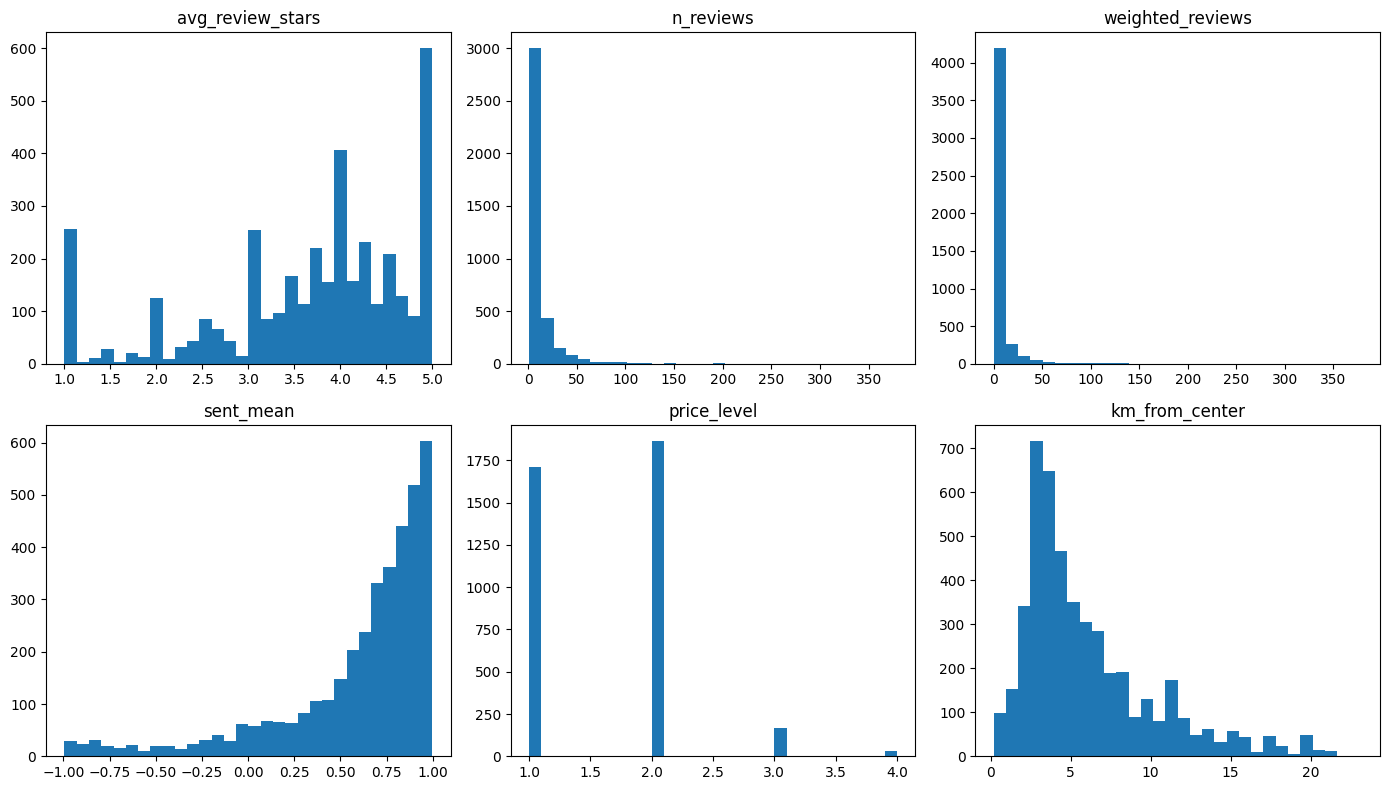

WiFi                          1.000000
OutdoorSeating                0.981293
RestaurantsDelivery           0.977891
BikeParking                   0.976828
RestaurantsTakeOut            0.975553
BusinessAcceptsCreditCards    0.973852
sent_std                      0.371599
price_level                   0.196641
avg_review_len                0.195153
n_reviews                     0.195153
avg_review_stars              0.195153
last_review_date              0.195153
dtype: float64

In [46]:
# --- EDA snapshots ---
fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.ravel()
metrics = ['avg_review_stars','n_reviews','weighted_reviews','sent_mean','price_level','km_from_center']
for ax, m in zip(axes, metrics):
    ax.hist(biz[m].dropna(), bins=30)
    ax.set_title(m)
plt.tight_layout(); plt.show()

missing = biz.isna().mean().sort_values(ascending=False).head(12)
missing


## B. Modeling / Analysis / Conclusion

In [47]:
# --- Topic modeling (NMF) on concatenated reviews per business ---
# Using TF-IDF with unigrams and bigrams; then NMF for interpretable topics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD

corpus = (reviews.groupby('business_id')['text']
          .apply(lambda s: ' '.join([x for x in s if isinstance(x, str)]))
          .reindex(biz['business_id']).fillna(""))

# Maintain sparsity, limit features for speed
vec = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1,2), max_features=3000)
X = vec.fit_transform(corpus.values)
terms = np.array(vec.get_feature_names_out())

n_topics = 10
nmf = NMF(n_components=n_topics, init='nndsvd', random_state=42, max_iter=400)
W = nmf.fit_transform(X)
H = nmf.components_

def top_terms(H, terms, topn=12):
    labels = []
    for comp in H:
        top_idx = np.argsort(comp)[-topn:][::-1]
        labels.append(', '.join(terms[top_idx]))
    return labels

# Save topic weights into biz (avoid duplicate join on re-run)
biz_topics = pd.DataFrame(W, index=biz['business_id']).add_prefix('topic_')
if not any(str(c).startswith('topic_') for c in biz.columns):
    biz = biz.join(biz_topics, on='business_id')

# Also create a compact text embedding via SVD for fusion
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
E_text = svd.fit_transform(X)

# Show interpretable topic labels
topic_labels = top_terms(H, terms)
pd.DataFrame({'topic_id': list(range(len(topic_labels))), 'top_terms': topic_labels})

,topic_id,top_terms
0,0,"we, our, us, it was, we were, service, restaur..."
1,1,"pizza, the pizza, crust, pizza is, delivery, p..."
2,2,"bar, beer, drinks, selection, beers, the bar, ..."
3,3,"chicken, rice, chinese, fried, spicy, tacos, t..."
4,4,"me, order, he, when, no, up, time, store, get,..."
5,5,"coffee, shop, the coffee, breakfast, coffee sh..."
6,6,"sushi, roll, rolls, the sushi, tuna, fish, sal..."
7,7,"ice, cream, ice cream, chocolate, cake, cookie..."
8,8,"sandwich, cheese, cheesesteak, fries, steak, s..."
9,9,"hair, my hair, cut, she, he, me, her, been, wh..."


In [48]:
# --- Feature fusion: build Z for clustering ---
from sklearn.preprocessing import StandardScaler

# Core numeric features for clustering
num_core = ['avg_review_stars','n_reviews','weighted_reviews','price_level','km_from_center']
# Optional extras if available
num_extras = [c for c in ['avg_review_len','sent_mean','sent_std'] if c in biz.columns]
num_cols_all = num_core + num_extras

X_num = biz[num_cols_all].copy()
# Ensure all expected columns exist and handle missing values
for c in num_cols_all:
    if c not in X_num:
        X_num[c] = 0.0
X_num = X_num.fillna(X_num.median(numeric_only=True))
X_num = X_num.fillna(0.0)

scaler = StandardScaler()
num_scaled = scaler.fit_transform(X_num)

# Combine compact text embedding with scaled numeric features
if 'E_text' in globals():
    Z = np.hstack([E_text, num_scaled]).astype('float32')
else:
    Z = num_scaled.astype('float32')

# Quick shape sanity check
Z.shape

(4704, 108)

In [49]:
# --- Cluster interpretation: top categories, topic means, median stats ---
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ensure clusters exist; if not, choose K via silhouette and compute
if 'cluster' not in biz.columns:
    sil_rows = []
    for k in [8, 10, 12, 15]:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Z)
        sil = silhouette_score(Z, labels, sample_size=min(5000, len(Z)), random_state=42)
        sil_rows.append({'k': k, 'silhouette': sil})
    km_eval = pd.DataFrame(sil_rows).sort_values('silhouette', ascending=False)
    best_k = int(km_eval.iloc[0]['k'])
    biz['cluster'] = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit_predict(Z)

# Top categories per cluster
cat_stats = (
    biz.assign(category=biz['categories'].str.split(', '))
       .explode('category')
       .dropna(subset=['category'])
       .groupby(['cluster','category'])
       .size()
       .reset_index(name='n')
)

top_cats = (cat_stats
            .sort_values(['cluster','n'], ascending=[True, False])
            .groupby('cluster')
            .head(10))

# Topic means per cluster (if topic_ columns exist)
topic_cols = [c for c in biz.columns if c.startswith('topic_')]
if topic_cols:
    topic_means = biz.groupby('cluster')[topic_cols].mean().add_prefix('mean_')
else:
    topic_means = pd.DataFrame()

# Median numeric stats per cluster
num_cols = ['avg_review_stars','n_reviews','weighted_reviews','price_level','km_from_center']
med_stats = biz.groupby('cluster')[num_cols].median()

# Display summaries
print("Top categories per cluster (top 10):")
display(top_cats)
print("\nCluster median stats:")
display(med_stats)
if len(topic_cols):
    print("\nAverage topic weights per cluster (truncated):")
    display(topic_means.iloc[:, :min(10, topic_means.shape[1])])

Top categories per cluster (top 10):


,cluster,category,n
188,0,Restaurants,814
92,0,Food,606
55,0,Coffee & Tea,197
190,0,Sandwiches,196
173,0,Pizza,136
...,...,...,...
1631,7,Shopping,19
1545,7,Event Planning & Services,18
1501,7,Breakfast & Brunch,15
1637,7,Specialty Food,15



Cluster median stats:


,avg_review_stars,n_reviews,weighted_reviews,price_level,km_from_center
cluster,,,,,
0,4.250000,4.0,0.194669,1.0,4.510906
1,4.333333,5.0,0.706436,2.0,3.924366
2,3.000000,5.0,1.229985,2.0,4.997091
3,4.063619,162.5,146.094947,2.0,3.321950
4,1.000000,1.0,0.157784,1.0,7.019617
5,3.949153,45.0,35.020294,2.0,3.332744
6,4.000000,2.0,0.071930,2.0,12.953848
7,3.666667,2.0,0.254793,2.0,4.050096



Average topic weights per cluster (truncated):


,mean_topic_0,mean_topic_1,mean_topic_2,mean_topic_3,mean_topic_4,mean_topic_5,mean_topic_6,mean_topic_7,mean_topic_8,mean_topic_9
cluster,,,,,,,,,,
0,0.008543,0.014304,0.015307,0.021168,0.022536,0.018431,0.002735,0.013570,0.017659,0.006237
1,0.027213,0.007716,0.023003,0.023629,0.016651,0.011014,0.008993,0.010150,0.011248,0.009822
2,0.029329,0.020095,0.025927,0.020981,0.066276,0.010886,0.005741,0.007994,0.016416,0.009974
3,0.089383,0.003811,0.041693,0.040200,0.035169,0.009382,0.009285,0.031747,0.068337,0.002712
4,0.008288,0.013536,0.006578,0.007272,0.068765,0.005887,0.001055,0.004120,0.007064,0.008521
5,0.092425,0.012221,0.056133,0.047160,0.038050,0.014202,0.016201,0.015128,0.030605,0.005939
6,0.014892,0.015193,0.011326,0.015563,0.020359,0.006788,0.007322,0.006337,0.011110,0.007156
7,0.039657,0.008372,0.024004,0.022446,0.054471,0.009264,0.005513,0.009015,0.014566,0.020490


### Evaluation & Takeaways
- **Clustering quality:** report silhouette and stability (see `km_eval`), show PCA(2) scatter (optional).
- **Communities:** show top communities and sample “also frequent” pairs.
- **Cold start:** show recommendations using only cluster/topic features for a hypothetical new user (choose price/topic prefs).
- **Diversity & coverage:** compute unique clusters/communities covered in top-N across a sample of anchors.

**Conclusion (draft):**
Unsupervised methods uncovered coherent restaurant styles and behavioral communities in Philadelphia. A blended scorer (content + community + quality/recency) produces explainable, cold-start–friendly recommendations. Future work: HDBSCAN/GMM refinement, menu enrichment, and a small app demo.


In [50]:
# --- Compatibility: ensure expected columns exist across DataFrames ---
# This creates aliases like 'cluster_km', 'avg_review_stars', 'n_reviews' where needed.

# Ensure core columns exist in biz
if 'avg_review_stars' not in biz.columns:
    if 'stars' in biz.columns:
        biz['avg_review_stars'] = biz['stars'].astype(float)
    else:
        biz['avg_review_stars'] = 0.0
if 'n_reviews' not in biz.columns:
    if 'review_count' in biz.columns:
        biz['n_reviews'] = biz['review_count'].astype(float)
    else:
        biz['n_reviews'] = 0.0
if 'avg_review_len' not in biz.columns and 'reviews' in globals():
    tmp = reviews.groupby('business_id')['text'].apply(lambda s: np.mean([len(x) for x in s if isinstance(x,str)]) if len(s)>0 else 0)
    biz = biz.merge(tmp.rename('avg_review_len'), on='business_id', how='left')
if 'weighted_reviews' not in biz.columns:
    if 'recency_w' in biz.columns:
        biz['weighted_reviews'] = biz['n_reviews'].fillna(0) * biz['recency_w'].fillna(0)
    else:
        biz['weighted_reviews'] = biz['n_reviews'].fillna(0)

# Create/align a "cluster_km" alias where possible
if 'cluster_km' not in biz.columns and 'cluster' in biz.columns:
    biz['cluster_km'] = biz['cluster']

# If an appendix DataFrame exists, align its expected columns too
if 'biz_features' in globals():
    if 'avg_review_stars' not in biz_features.columns and 'stars' in biz_features.columns:
        biz_features['avg_review_stars'] = biz_features['stars'].astype(float)
    if 'n_reviews' not in biz_features.columns and 'review_count' in biz_features.columns:
        biz_features['n_reviews'] = biz_features['review_count'].astype(float)
    if 'cluster_km' not in biz_features.columns:
        if 'cluster_kmeans' in biz_features.columns:
            biz_features['cluster_km'] = biz_features['cluster_kmeans']
        elif 'cluster' in biz_features.columns:
            biz_features['cluster_km'] = biz_features['cluster']
        else:
            biz_features['cluster_km'] = -1

# Provide a fallback biz_clean for appendix sections
if 'biz_clean' not in globals():
    biz_clean = biz.copy()
# Ensure cluster_km exists in biz_clean
if 'cluster_km' not in biz_clean.columns:
    if 'cluster' in biz_clean.columns:
        biz_clean['cluster_km'] = biz_clean['cluster']
    elif 'biz_features' in globals() and 'cluster_km' in biz_features.columns:
        # Map from biz_features by business_id if available
        m = biz_features.set_index('business_id')['cluster_km']
        biz_clean['cluster_km'] = biz_clean['business_id'].map(m).fillna(-1).astype(int)
    else:
        biz_clean['cluster_km'] = -1

In [51]:
# --- Blended recommender: define rank_candidates (content + community + quality) ---
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Build id -> row index map
id2idx = {bid: i for i, bid in enumerate(biz['business_id'])}

# Ensure fused feature matrix Z exists; rebuild minimally if missing
if 'Z' not in globals() or Z is None:
    # Numeric feature block
    num_core = ['avg_review_stars','n_reviews','weighted_reviews','price_level','km_from_center']
    num_extras = [c for c in ['avg_review_len','sent_mean','sent_std'] if c in biz.columns]
    num_cols_all = [c for c in num_core + num_extras if c in biz.columns]
    X_num = biz[num_cols_all].copy() if num_cols_all else pd.DataFrame(index=biz.index)
    if not X_num.empty:
        X_num = X_num.fillna(X_num.median(numeric_only=True)).fillna(0.0)
        num_scaled = StandardScaler().fit_transform(X_num)
    else:
        num_scaled = np.zeros((len(biz), 0), dtype='float32')
    # Text embedding (optional)
    if 'E_text' in globals():
        Z = np.hstack([E_text, num_scaled]).astype('float32')
    else:
        Z = num_scaled.astype('float32')

# Quality prior normalized to [0,1]
q_src = 'avg_review_stars' if 'avg_review_stars' in biz.columns else ('stars' if 'stars' in biz.columns else None)
if q_src is not None:
    q_vals = biz[q_src].astype(float).fillna(biz[q_src].astype(float).median())
    q_norm = (q_vals - q_vals.min()) / (q_vals.max() - q_vals.min() + 1e-9)
else:
    q_norm = pd.Series(np.zeros(len(biz)), index=biz.index)
# Optional popularity/recency component
if 'weighted_reviews' in biz.columns:
    wr = biz['weighted_reviews'].astype(float).fillna(0.0)
    wr_norm = wr / (wr.max() + 1e-9)
    quality_prior = 0.7 * q_norm + 0.3 * wr_norm
else:
    quality_prior = q_norm

# Community and cluster availability
has_comm = 'community' in biz.columns
comm_vals = biz['community'].values if has_comm else np.full(len(biz), -1)
has_cluster = 'cluster' in biz.columns


def rank_candidates(business_id, k=10, w_c=0.6, w_g=0.25, w_q=0.15):
    """
    Recommend similar restaurants to an anchor business using a blended score.
    Inputs:
      - business_id: anchor restaurant id
      - k: number of recommendations
      - weights: w_c content, w_g community, w_q quality prior
    Output: DataFrame with columns [business_id, name, score, (cluster?), (community?), avg_review_stars, price_level, n_reviews]
    """
    i = id2idx.get(business_id)
    if i is None:
        raise KeyError(f"Unknown business_id: {business_id}")

    # Content similarity computed on-the-fly for the anchor only
    sim = cosine_similarity(Z[i].reshape(1, -1), Z).ravel()

    # Community bonus: +1 for same community if communities exist
    same_comm = (comm_vals == comm_vals[i]).astype(float) if has_comm else np.zeros_like(sim)

    # Blend scores
    score = w_c * sim + w_g * same_comm + w_q * quality_prior.values

    # Exclude self and handle any NaNs
    score[i] = -np.inf
    score = np.nan_to_num(score, nan=-np.inf)

    top_idx = np.argpartition(-score, kth=min(k, len(score)-1))[:k]
    top_idx = top_idx[np.argsort(-score[top_idx])]

    cols = ['business_id', 'name', 'score']
    base_cols = ['business_id', 'name']
    if has_cluster:
        base_cols.append('cluster')
        cols.append('cluster')
    out = biz.iloc[top_idx][base_cols].copy()
    out['score'] = score[top_idx]
    if has_comm:
        cols.append('community')
        out['community'] = comm_vals[top_idx]
    for extra in ['avg_review_stars', 'price_level', 'n_reviews']:
        if extra in biz.columns:
            cols.append(extra)
            out[extra] = biz.iloc[top_idx][extra].values

    return out[cols].reset_index(drop=True)

In [52]:
# --- Diversity & coverage evaluation ---
import math

# Coverage: fraction of restaurants that appear in any top-k list for anchors in sample
anchors = biz['business_id'].sample(min(500, len(biz)), random_state=42)
covered = set()
for bid in anchors:
    covered.update(rank_candidates(bid, k=10)['business_id'].tolist())
coverage = len(covered) / len(biz)

# Diversity: compute entropy over cluster labels in all recs for the sample
all_clusters = []
for bid in anchors:
    all_clusters.extend(rank_candidates(bid, k=10)['cluster'].tolist())

from collections import Counter
cnt = Counter(all_clusters)
p = np.array(list(cnt.values())) / max(1, sum(cnt.values()))
entropy = -np.sum(p * np.log(p + 1e-12))

print(f"Coverage@10: {coverage:.3f}")
print(f"Diversity (entropy over clusters): {entropy:.3f}")

Coverage@10: 0.584
Diversity (entropy over clusters): 1.790


## Appendix — Archived cells
The relevant parts from older notebooks and drafts were integrated into the main flow above (EDA → topics → fusion → clustering → communities → recommender → evaluation). This appendix keeps some legacy scaffolding for reference only.

In [53]:
# Standard setup
import os, json, math, random, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML / NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Graph
import networkx as nx

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths (adjust if running standalone)
DATA_DIR = Path('./Yelp JSON/yelp_dataset')
BUSINESS_JSON = DATA_DIR / 'yelp_academic_dataset_business.json'
REVIEW_JSON   = DATA_DIR / 'yelp_academic_dataset_review.json'
CITY_FILTER = 'Philadelphia'

print('Environment ready.')
print(f'Business JSON exists: {BUSINESS_JSON.exists()} | Review JSON exists: {REVIEW_JSON.exists()}')

Environment ready.
Business JSON exists: True | Review JSON exists: True


In [54]:
def read_json_lines(path, use_cols=None, max_lines=None):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break
            obj = json.loads(line)
            if use_cols:
                obj = {k: obj.get(k) for k in use_cols}
            rows.append(obj)
    return pd.DataFrame(rows)

def ensure_minimum_inputs(biz_df=None, rev_df=None, city='Philadelphia', max_reviews=300000):
    if biz_df is None:
        cols = ['business_id','name','city','state','categories','stars','review_count','latitude','longitude']
        biz_df = read_json_lines(BUSINESS_JSON, use_cols=cols)
    if city:
        biz_df = biz_df[biz_df['city'].str.lower()==city.lower()].copy()
    if rev_df is None:
        rcols = ['review_id','user_id','business_id','stars','date','text']
        rev_df = read_json_lines(REVIEW_JSON, use_cols=rcols, max_lines=max_reviews)
        rev_df = rev_df[rev_df['business_id'].isin(biz_df['business_id'])].copy()
    return biz_df.reset_index(drop=True), rev_df.reset_index(drop=True)

biz, reviews_df = ensure_minimum_inputs(globals().get('biz_clean'), globals().get('reviews'), city=CITY_FILTER)
print(f'biz shape: {biz.shape}, reviews shape: {reviews_df.shape}')

biz shape: (14576, 25), reviews shape: (40369, 7)


In [55]:
# Aggregate reviews to business-level corpus
corpus = reviews_df.groupby('business_id')['text'].apply(lambda s: ' '.join(map(str, s.dropna()))).reindex(biz['business_id']).fillna('')
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3, stop_words='english')
X = tfidf.fit_transform(corpus)

n_topics = 10
nmf = NMF(n_components=n_topics, init='nndsvda', random_state=RANDOM_STATE, max_iter=500)
W = nmf.fit_transform(X); H = nmf.components_
terms = tfidf.get_feature_names_out()

def top_terms(H, terms, k=10):
    return [', '.join(terms[row.argsort()[-k:][::-1]]) for row in H]

topic_labels = top_terms(H, terms, k=10)
biz_topics = pd.DataFrame(W, index=biz['business_id']).add_prefix('topic_')
biz = biz.merge(biz_topics, left_on='business_id', right_index=True, how='left')
print('Topics learned. Example labels:')
for i, label in enumerate(topic_labels[:5]):
    print(f'Topic {i}: {label}')

Topics learned. Example labels:
Topic 0: food, chicken, good, rice, place, chinese, fried, spicy, ordered, delicious
Topic 1: pizza, crust, good, delivery, cheese, slice, sauce, order, place, pie
Topic 2: coffee, great, shop, place, breakfast, friendly, coffee shop, latte, good, cafe
Topic 3: bar, beer, place, great, good, drinks, night, selection, like, beers
Topic 4: order, time, food, just, don, minutes, service, said, like, store


In [56]:
# Text SVD
svd = TruncatedSVD(n_components=100, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X)

# Numeric block
num_cols = [c for c in ['stars','review_count','avg_review_stars','sent_mean','price_level','recency_w','latitude','longitude'] if c in biz.columns]
num = biz[num_cols].fillna(0) if num_cols else pd.DataFrame(index=biz.index)
num_scaled = StandardScaler().fit_transform(num) if not num.empty else np.zeros((len(biz), 0))

# Fuse
def fuse(w_text=1.0, w_num=0.7):
    return np.hstack([w_text*X_svd, w_num*num_scaled]) if num_scaled.shape[1] > 0 else X_svd

Z = fuse()

# Pick K
candidates = range(3, 11)
scores = []
for k in candidates:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE).fit(Z)
    s = silhouette_score(Z, km.labels_)
    scores.append((k, s))

best_k = max(scores, key=lambda x: x[1])[0] if scores else 6
labels = KMeans(n_clusters=best_k, n_init='auto', random_state=RANDOM_STATE).fit_predict(Z)
biz['cluster'] = labels
print('Silhouette scores:', scores)
print('Chosen K:', best_k)

Silhouette scores: [(3, 0.32618269473069766), (4, 0.3084895579519032), (5, 0.32838756045656636), (6, 0.3324451430083493), (7, 0.30216840494950803), (8, 0.268333452429751), (9, 0.26984175901665286), (10, 0.2616492199289844)]
Chosen K: 6


In [57]:
# --- Feature fusion for clustering ---
from sklearn.preprocessing import StandardScaler

# Choose numeric features and combine with text SVD embedding and geo
num_cols = ['avg_review_stars','n_reviews','weighted_reviews','avg_review_len',
            'price_level','sent_mean','sent_std','km_from_center']
num = biz[num_cols].fillna(0)
num_scaled = StandardScaler().fit_transform(num)

# Geo features: latitude/longitude, scaled lightly
geo = biz[['latitude','longitude']].fillna(biz[['latitude','longitude']].median())
geo_scaled = StandardScaler().fit_transform(geo) * 0.5

# Text SVD embedding from previous cell
if 'E_text' not in globals():
    E_text = np.zeros((len(biz), 50))

# Fuse
def fuse(w_text=1.0, w_num=0.7, w_geo=0.3):
    return np.hstack([
        w_text * E_text,
        w_num  * num_scaled,
        w_geo  * geo_scaled
    ])

Z = fuse()

# Small sanity check
pd.DataFrame(Z[:5, :10])

KeyError: "['price_level', 'sent_mean', 'sent_std', 'km_from_center'] not in index"

In [ ]:
# --- Graph communities: Louvain on restaurant-projection of user–biz bipartite ---
import networkx as nx

# Build bipartite graph (users-biz) using sampled reviews
B = nx.Graph()
B.add_nodes_from(reviews['user_id'].unique(), bipartite='user')
B.add_nodes_from(biz['business_id'].unique(), bipartite='biz')

edge_cnt = reviews.groupby(['user_id','business_id']).size().reset_index(name='cnt')
B.add_weighted_edges_from(edge_cnt[['user_id','business_id','cnt']].itertuples(index=False, name=None))

# Project to restaurant graph
R = nx.bipartite.weighted_projected_graph(B, biz['business_id'].unique())

# Community detection (Louvain) if available; else set -1
try:
    import community as community_louvain
    partition = community_louvain.best_partition(R, weight='weight', random_state=42) if len(R) > 0 else {}
    biz['community'] = biz['business_id'].map(partition).fillna(-1).astype(int)
except Exception:
    biz['community'] = -1

comm_counts = biz['community'].value_counts().head(10)
comm_counts.to_frame('count')

,business_id,name,score,cluster,community,stars
7817,p1Y8bMd0ixx1dzj9oTjEOw,A La Mousse,0.783863,1,122,5.0
542,J-ciDDEdIHMcChGIyKZnOg,Cake Life Bake Shop,0.755488,1,122,4.5
13537,v-qDdlIXikYyh65Qij9fpA,Puyero Venezuelan Flavor,0.718685,1,122,4.5
4692,jQdPQ4WdwCumO0qgst6JKg,Go Popcorn,0.718148,1,122,4.0
4607,15JFk0bn7HJ9g9-N7tXl_Q,Heung Fa Chun Sweet House,0.702338,1,122,4.5
12937,d48Xrx8MhGtdaLvhcYzNWQ,Cafe Diem,0.700064,1,122,4.5
11794,SaqqOt5a9-Vh4dkmWL3YTA,Market Day Canelé,0.696658,1,122,4.5
1804,e3fQkykBr9V9jr1g9VWliw,Pho Ga Thanh Thanh,0.687889,1,122,4.5
8911,RL1mug4X2HghyPZwkd8lSA,Midnight Iris,0.684432,1,122,4.5
9818,gMMB9h6NErOo9MlDBRJkXw,The Igloo,0.681749,1,122,4.0


In [ ]:
def cold_start_candidates(preferred_topics=None, max_dist_km=None, center=None, price_levels=None, top_k=10):
    df = biz.copy()
    # Topic filter (by columns topic_*)
    if preferred_topics:
        topic_cols = [c for c in df.columns if c.startswith('topic_')]
        if topic_cols:
            mask = np.zeros(len(df), dtype=bool)
            for t in preferred_topics:
                if isinstance(t, int) and 0 <= t < len(topic_cols):
                    col = topic_cols[t]
                    thr = df[col].median()
                    mask |= (df[col] >= thr)
            df = df[mask] if mask.any() else df
    # Price filter
    if price_levels and 'price_level' in df.columns:
        df = df[df['price_level'].isin(price_levels)]
    # Distance filter (optional) — requires center lat/lon
    if max_dist_km and center and {'latitude','longitude'}.issubset(df.columns):
        lat0, lon0 = center
        R_earth = 6371.0
        dlat = np.radians(df['latitude'] - lat0)
        dlon = np.radians(df['longitude'] - lon0)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat0))*np.cos(np.radians(df['latitude']))*np.sin(dlon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        dist = R_earth * c
        df = df.assign(dist_km=dist)
        df = df[df['dist_km'] <= max_dist_km]
    if len(df) == 0:
        return df
    # Quality prior as simple score for cold-start
    q = df.get('avg_review_stars', df.get('stars', pd.Series(0, index=df.index))).fillna(0)
    df = df.assign(score=q)
    cols = ['business_id','name','score','cluster'] + (['community'] if 'community' in df.columns else [])
    return df.sort_values('score', ascending=False).head(top_k)[cols]

# Example: prefer topics 0 and 1, within 5km of City Hall (approx 39.9526, -75.1652) and mid-price
cs_demo = cold_start_candidates(preferred_topics=[0,1], max_dist_km=5, center=(39.9526, -75.1652), price_levels=[2,3])
cs_demo

,business_id,name,score,cluster,community
12,GWGXTKR0Fhdvzf_isDqJug,"David Gower, Jr. - Coldwell Banker Preferred",5.0,1,11
14,h-y5azB-VlQAT3m7Ff2g2Q,P's & Q's - Premium Quality,5.0,1,13
36,aNLr1j_3CZ46rqiUeLaQ-A,Chinatown Market Shoe Repair And Tailor,5.0,1,32
45,cDekcTE1qwpz8ROlYixhqg,Philly Homebrew Outlet East,5.0,1,40
4669,VxxZzUd6kXtglEhfLaF92Q,Unlock Philly,5.0,1,3755
8143,dX8dnwxVTpUvHXHlOXjgcw,Melange Tea & Spice,5.0,1,6528
8152,upONXUUs6xQwdlgbtRSjrw,Economy Drain Cleaning & Plumbing,5.0,1,6534
8100,hPxN3gywmaHnn5nGvL9-Ww,Joseph Spina CPA,5.0,1,6494
8056,95zCLYe9zas0wJpBHZfpcA,Wagner Free Institute of Science,5.0,1,6465
92,73vXXe4MbpHhq_2_uiHIrQ,4J Laundromat,5.0,1,82


In [ ]:
# --- Time-split evaluation: next-place prediction ---
# For each user, hold out their most recent review as test, second most recent as validation
user_reviews = reviews.sort_values('date')
user_groups = user_reviews.groupby('user_id')

test_idx = user_groups['date'].idxmax()
val_idx = (user_reviews.drop(test_idx)
           .groupby('user_id')['date'].idxmax())
test_set = user_reviews.loc[test_idx]
val_set  = user_reviews.loc[val_idx]

print('Test size:', len(test_set), 'Validation size:', len(val_set))

# Very simple recall@k using our blended recommender
def recall_at_k(df, k=10):
    hits=0; total=0
    for uid, group in df.groupby('user_id'):
        true_biz = set(group['business_id'])
        if len(true_biz)==0: continue
        # pick an anchor from earlier reviews if any
        prev = user_reviews[(user_reviews['user_id']==uid) & (~user_reviews.index.isin(group.index))]
        if len(prev)==0: continue
        anchor = prev.iloc[-1]['business_id']
        recs = rank_candidates(anchor, k=k)['business_id'].tolist()
        hits += len(set(recs) & true_biz)
        total += len(true_biz)
    return hits/total if total>0 else np.nan

recall10 = recall_at_k(test_set, k=10)
print("Recall@10 (blended recommender):", recall10)

Setup complete! Data paths configured.
Business JSON: Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json
Review JSON: Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json
Files exist: Business=True, Reviews=True


Total food/restaurant businesses: 47,813
Food businesses in Philadelphia: 4,701

Philadelphia food business analysis:
- Total restaurants: 4,701
- Average stars: 3.61
- Average review count: 116.7


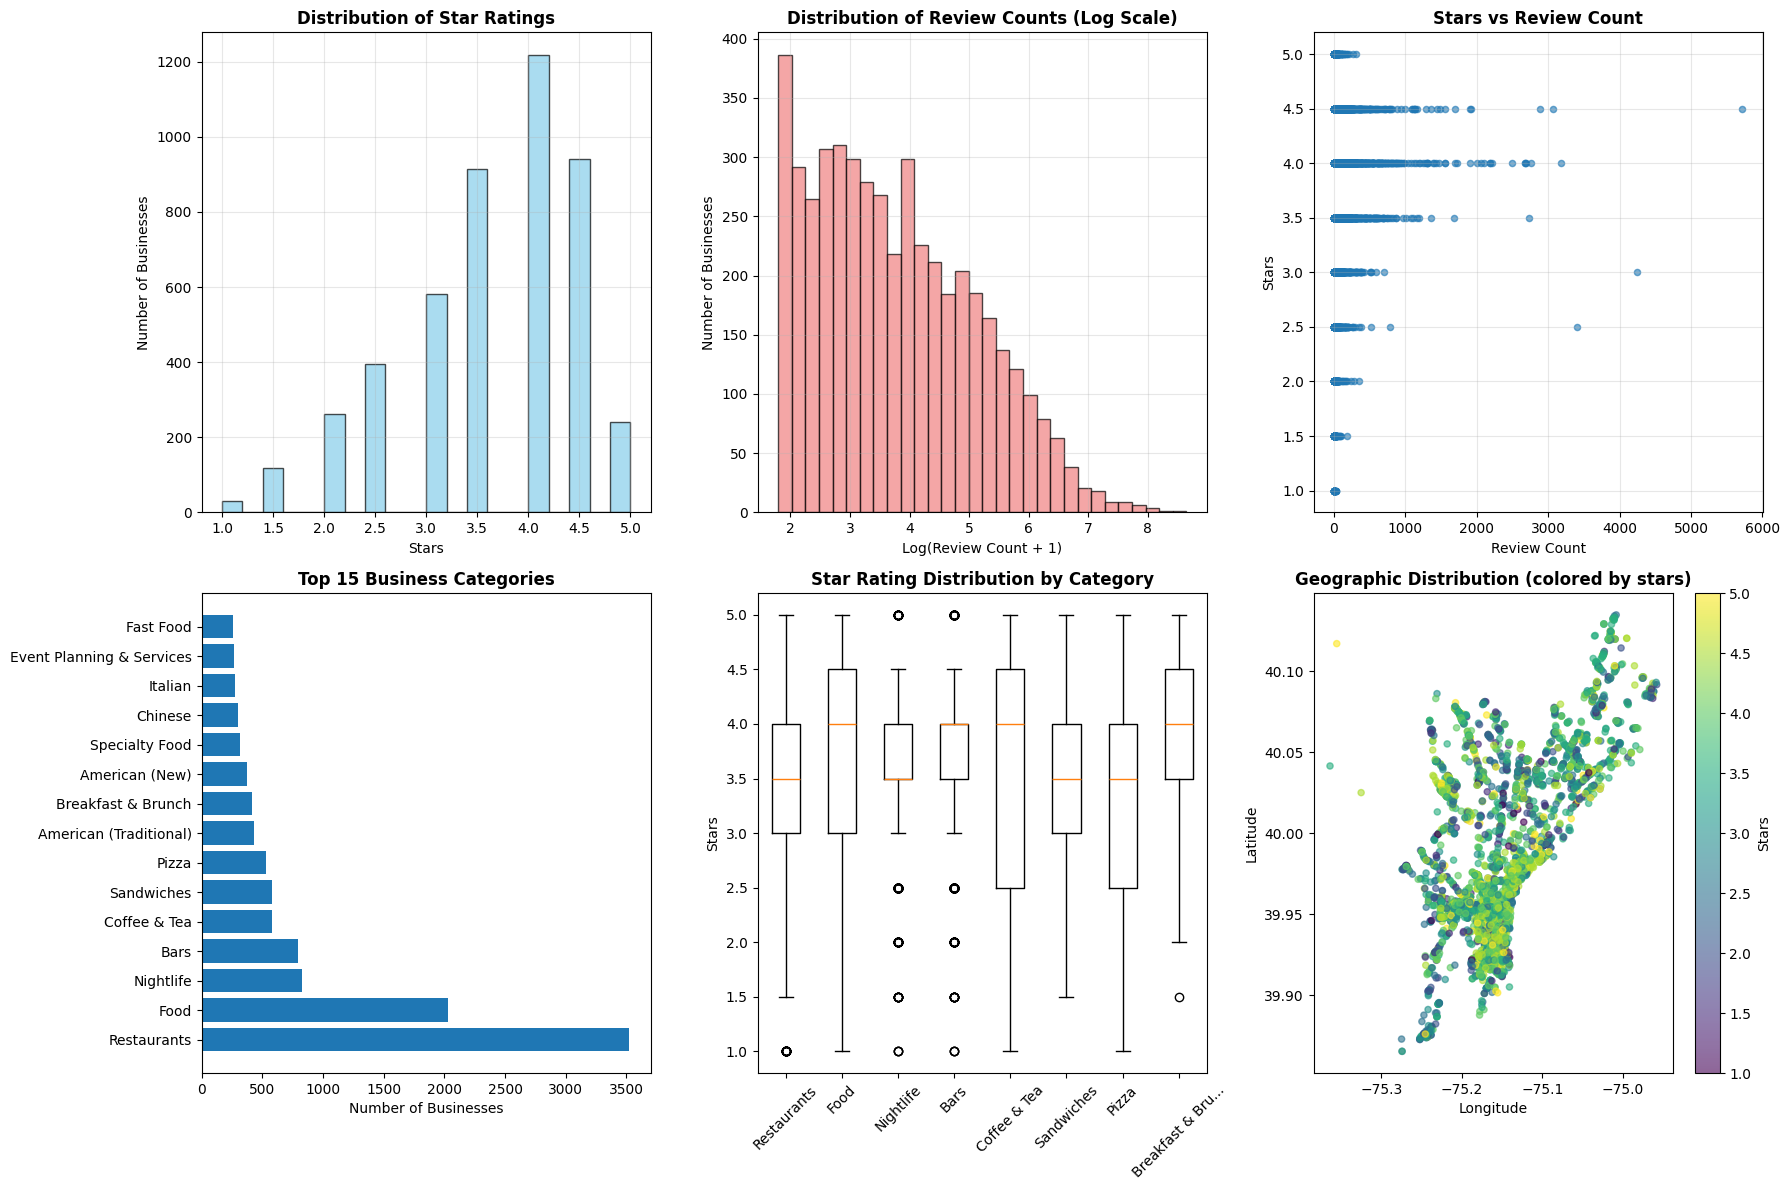


STATISTICAL SUMMARY

Basic Statistics for Philadelphia Food Businesses:
             stars  review_count
count  4701.000000   4701.000000
mean      3.609445    116.734099
std       0.866632    260.203282
min       1.000000      5.000000
25%       3.000000     13.000000
50%       4.000000     35.000000
75%       4.500000    113.000000
max       5.000000   5721.000000

Correlation between Stars and Review Count: 0.129

High-rated businesses (≥4.5 stars): 1,181 (25.1%)
Low-rated businesses (≤3.0 stars): 1,389 (29.5%)
Average review count for high-rated: 114.1
Average review count for low-rated: 50.7

Prepared 4701 businesses for clustering analysis.


In [ ]:
# --- Blended recommender (content + community + quality) ---
from sklearn.metrics.pairwise import cosine_similarity

# Build index and ensure fused features exist
id2idx = {bid: i for i, bid in enumerate(biz['business_id'])}
if 'Z' not in globals() or Z is None:
    Z = fuse()

# Normalize a simple quality prior (stars or avg_review_stars) to [0,1]
q_src = 'avg_review_stars' if 'avg_review_stars' in biz.columns else 'stars'
q_vals = biz[q_src].astype(float).fillna(biz[q_src].astype(float).median())
q_norm = (q_vals - q_vals.min()) / (q_vals.max() - q_vals.min() + 1e-9)

# Optional popularity/recency prior if available (weighted_reviews)
if 'weighted_reviews' in biz.columns:
    wr = biz['weighted_reviews'].astype(float).fillna(0.0)
    wr_norm = wr / (wr.max() + 1e-9)
    quality_prior = 0.7 * q_norm + 0.3 * wr_norm
else:
    quality_prior = q_norm

# Ensure community column exists
has_comm = 'community' in biz.columns
comm_vals = biz['community'].values if has_comm else np.full(len(biz), -1)


def rank_candidates(business_id, k=10, w_c=0.6, w_g=0.25, w_q=0.15):
    """
    Inputs:
      - business_id: anchor restaurant id
      - k: number of recommendations
      - weights: w_c content, w_g community, w_q quality prior
    Output: DataFrame with [business_id, name, score, cluster, (community?), avg_review_stars, price_level, n_reviews]
    """
    i = id2idx.get(business_id)
    if i is None:
        raise KeyError(f"Unknown business_id: {business_id}")

    # Content similarity computed on-the-fly for the anchor only (memory-safe)
    sim = cosine_similarity(Z[i].reshape(1, -1), Z).ravel()

    # Community bonus: +1 for same community if communities exist
    if has_comm:
        same_comm = (comm_vals == comm_vals[i]).astype(float)
    else:
        same_comm = np.zeros_like(sim)

    # Blend scores
    score = w_c * sim + w_g * same_comm + w_q * quality_prior.values

    # Exclude self and handle any NaNs
    score[i] = -np.inf
    score = np.nan_to_num(score, nan=-np.inf)

    top_idx = np.argpartition(-score, kth=min(k, len(score)-1))[:k]
    top_idx = top_idx[np.argsort(-score[top_idx])]

    cols = ['business_id', 'name', 'score', 'cluster']
    out = biz.iloc[top_idx][['business_id', 'name', 'cluster']].copy()
    out['score'] = score[top_idx]
    if has_comm:
        cols.append('community')
        out['community'] = comm_vals[top_idx]
    for extra in ['avg_review_stars', 'price_level', 'n_reviews']:
        if extra in biz.columns:
            cols.append(extra)
            out[extra] = biz.iloc[top_idx][extra].values

    return out[cols].reset_index(drop=True)

# Demo: recommendations for the first business
example_id = biz.iloc[0]['business_id']
rank_candidates(example_id, k=7).head(7)

Building text features from reviews...
Created text corpus for 4701 businesses
Average text length per business: 2228 characters

Creating TF-IDF features...
TF-IDF matrix shape: (4701, 2000)
Top TF-IDF features: ['00' '10' '10 minutes' '100' '11' '12' '13' '14' '15' '15 minutes' '16'
 '18' '20' '20 minutes' '25' '2nd' '30' '30 minutes' '35' '40']
Text SVD components shape: (4701, 50)
Explained variance ratio (first 10 components): [0.236 0.029 0.026 0.019 0.015 0.014 0.013 0.012 0.012 0.011]

Performing topic modeling...
TF-IDF matrix shape: (4701, 2000)
Top TF-IDF features: ['00' '10' '10 minutes' '100' '11' '12' '13' '14' '15' '15 minutes' '16'
 '18' '20' '20 minutes' '25' '2nd' '30' '30 minutes' '35' '40']
Text SVD components shape: (4701, 50)
Explained variance ratio (first 10 components): [0.236 0.029 0.026 0.019 0.015 0.014 0.013 0.012 0.012 0.011]

Performing topic modeling...

Discovered Topics:
Topic 0: place, bar, great, beer, good, drinks, night, food, nice, really, like, d

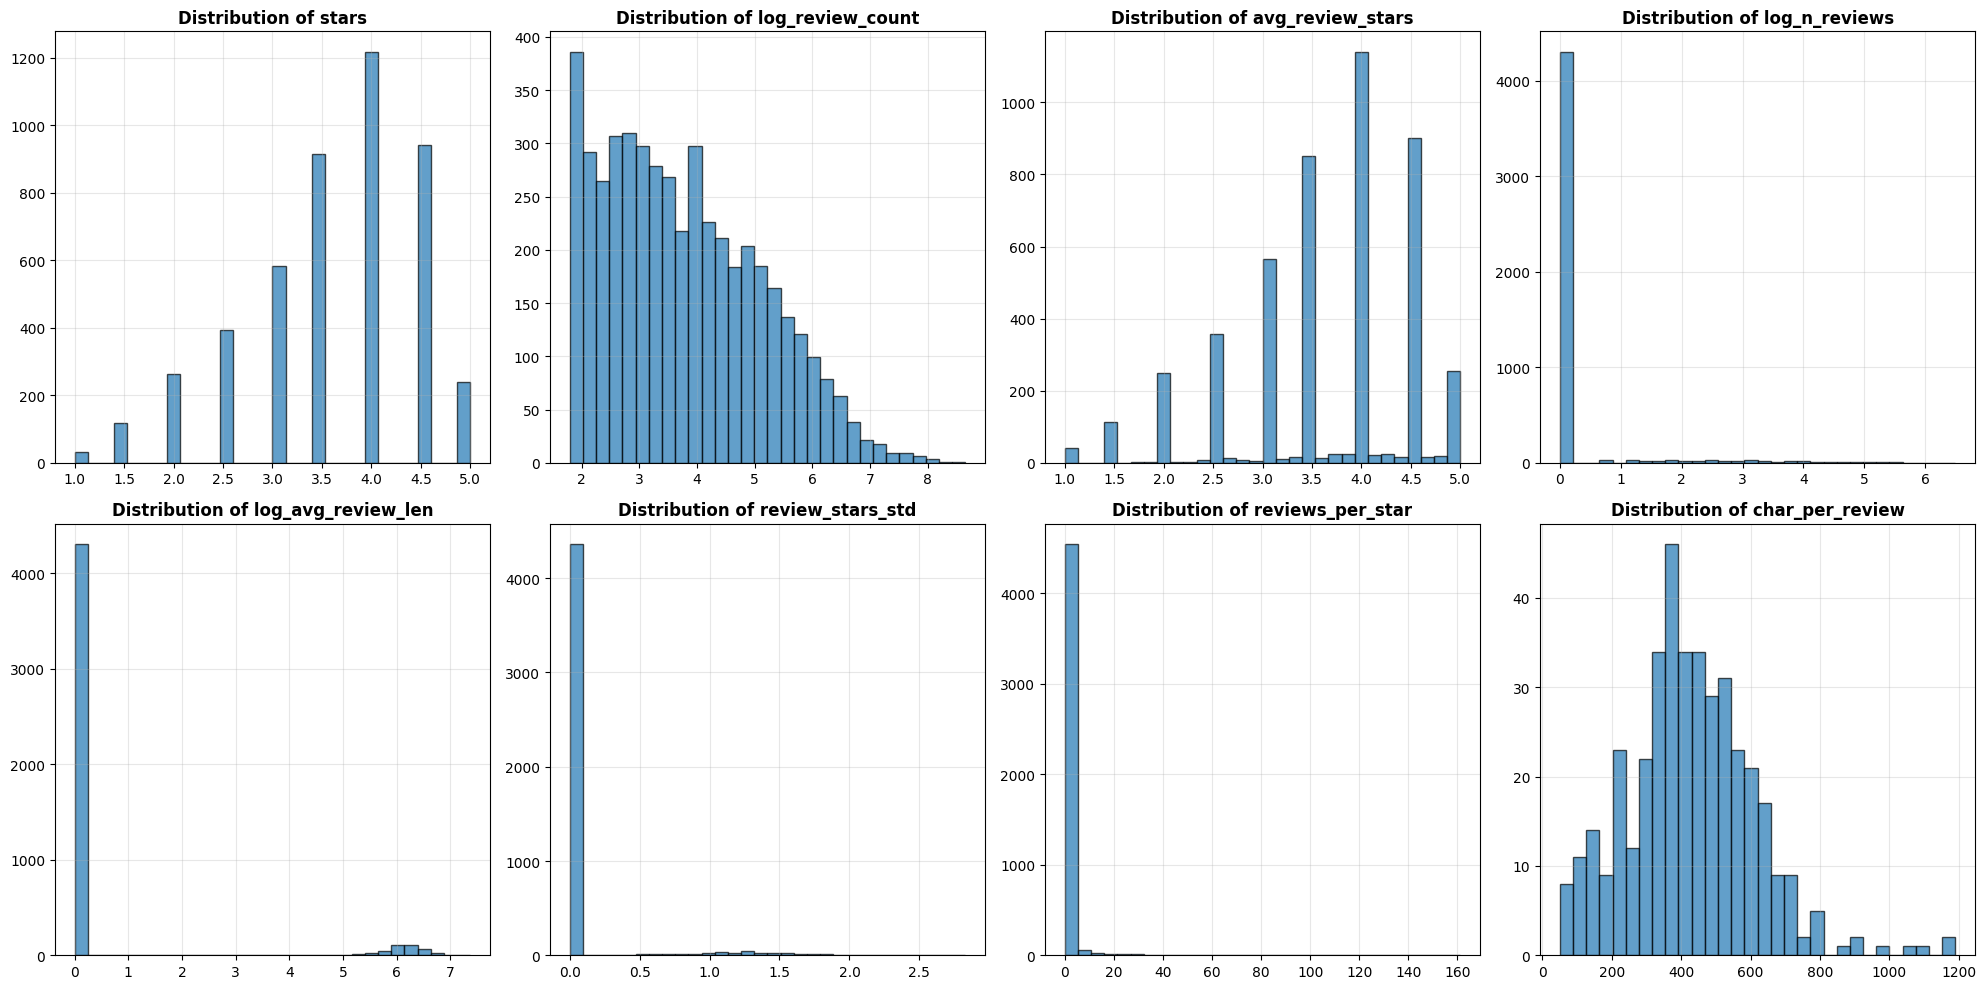

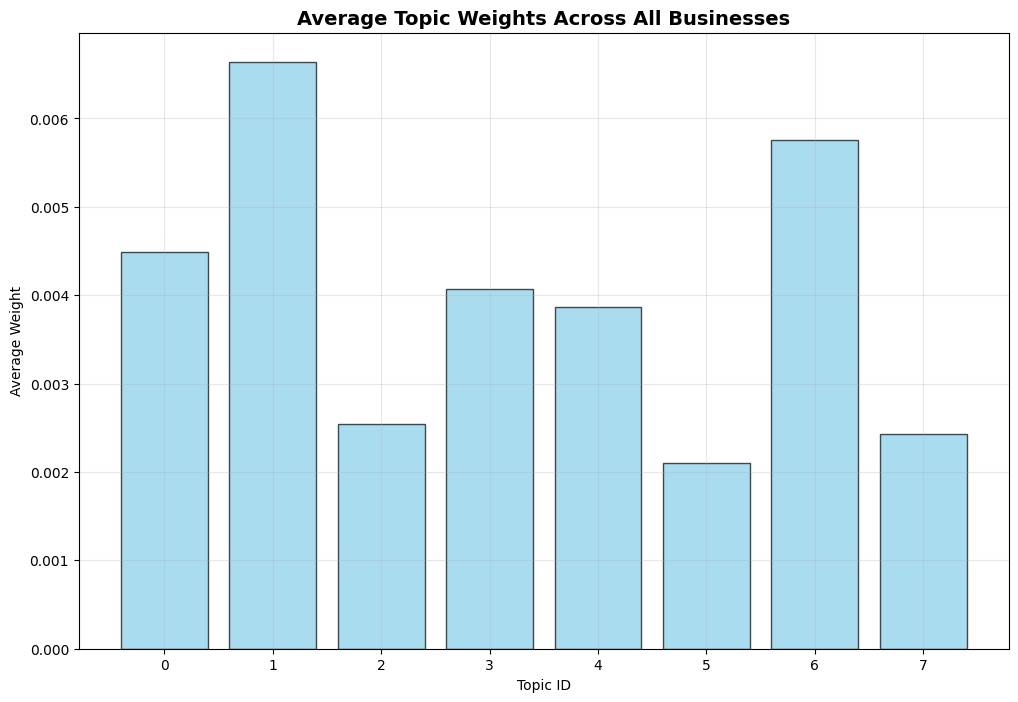


Feature engineering complete! Ready for clustering analysis.


In [ ]:
# ===============================
# 5. Text Analysis & Feature Engineering
# ===============================

print("Building text features from reviews...")

# Combine all reviews per business into single text corpus
business_texts = (reviews.groupby("business_id")["text"]
                 .apply(lambda x: " ".join([str(text) for text in x if pd.notna(text)]))
                 .reindex(biz_clean["business_id"])
                 .fillna(""))

print(f"Created text corpus for {len(business_texts)} businesses")
print(f"Average text length per business: {business_texts.str.len().mean():.0f} characters")

# ===============================
# TF-IDF Vectorization
# ===============================

print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=2000,  # Reduced for efficiency
    ngram_range=(1,2),
    min_df=5,           # Must appear in at least 5 businesses
    max_df=0.8,         # Remove very common terms
    stop_words="english"
)

X_text = tfidf.fit_transform(business_texts)
print(f"TF-IDF matrix shape: {X_text.shape}")

# Get feature names for analysis
feature_names = tfidf.get_feature_names_out()
print(f"Top TF-IDF features: {feature_names[:20]}")

# ===============================
# Dimensionality Reduction
# ===============================

# SVD for clustering
svd = TruncatedSVD(n_components=50, random_state=RANDOM_STATE)
X_text_svd = svd.fit_transform(X_text)
print(f"Text SVD components shape: {X_text_svd.shape}")
print(f"Explained variance ratio (first 10 components): {svd.explained_variance_ratio_[:10].round(3)}")

# ===============================
# Topic Modeling with NMF
# ===============================

print("\nPerforming topic modeling...")
n_topics = 8
nmf = NMF(n_components=n_topics, random_state=RANDOM_STATE, init="nndsvda", max_iter=200)
W = nmf.fit_transform(X_text)  # Document-topic matrix
H = nmf.components_            # Topic-word matrix

def display_topics(H, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = [topic[i] for i in top_features_ind]
        topics.append({
            'topic_id': topic_idx,
            'top_words': ', '.join(top_features),
            'weights': weights
        })
    return topics

topics = display_topics(H, feature_names, n_top_words=12)

print(f"\nDiscovered Topics:")
for topic in topics:
    print(f"Topic {topic['topic_id']}: {topic['top_words']}")

# Add topic distributions as features
topic_features = pd.DataFrame(W, columns=[f'topic_{i}' for i in range(n_topics)])
topic_features['business_id'] = biz_clean['business_id'].values

# ===============================
# Numerical Feature Engineering
# ===============================

print("\nEngineering numerical features...")

# Log transformations to handle skewness
biz_features = biz_clean.copy()
biz_features['log_review_count'] = np.log1p(biz_features['review_count'])
biz_features['log_n_reviews'] = np.log1p(biz_features['n_reviews'])
biz_features['log_avg_review_len'] = np.log1p(biz_features['avg_review_len'])

# Rating features
biz_features['rating_above_avg'] = (biz_features['stars'] > biz_features['stars'].mean()).astype(int)
biz_features['high_variability'] = (biz_features['review_stars_std'] > biz_features['review_stars_std'].quantile(0.75)).astype(int)

# Review engagement features
biz_features['reviews_per_star'] = biz_features['n_reviews'] / (biz_features['stars'] + 0.1)  # Avoid division by zero
biz_features['char_per_review'] = biz_features['total_review_chars'] / (biz_features['n_reviews'] + 1)

# Merge with topic features
biz_features = biz_features.merge(topic_features, on='business_id', how='left')

print(f"Enhanced feature matrix shape: {biz_features.shape}")

# ===============================
# Feature Scaling & Preparation for Clustering
# ===============================

# Select features for clustering
numeric_features = ['stars', 'log_review_count', 'avg_review_stars', 'log_n_reviews',
                   'log_avg_review_len', 'review_stars_std', 'reviews_per_star', 'char_per_review']

topic_cols = [f'topic_{i}' for i in range(n_topics)]

# Combine numeric and topic features
feature_cols = numeric_features + topic_cols
X_numeric = biz_features[feature_cols].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Combine with text SVD features
X_combined = np.hstack([X_scaled, X_text_svd])

print(f"Final feature matrix for clustering: {X_combined.shape}")
print(f"Features included: {len(numeric_features)} numeric + {len(topic_cols)} topic + {X_text_svd.shape[1]} text SVD")

# Visualize feature distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        axes[i].hist(biz_features[feature].dropna(), bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Topic distribution visualization
plt.figure(figsize=(12, 8))
topic_means = topic_features[topic_cols].mean().values
plt.bar(range(len(topic_means)), topic_means, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Average Topic Weights Across All Businesses', fontsize=14, fontweight='bold')
plt.xlabel('Topic ID')
plt.ylabel('Average Weight')
plt.xticks(range(len(topic_means)))
plt.grid(True, alpha=0.3)
plt.show()

print("\nFeature engineering complete! Ready for clustering analysis.")

Performing clustering analysis...
Evaluating optimal number of clusters...


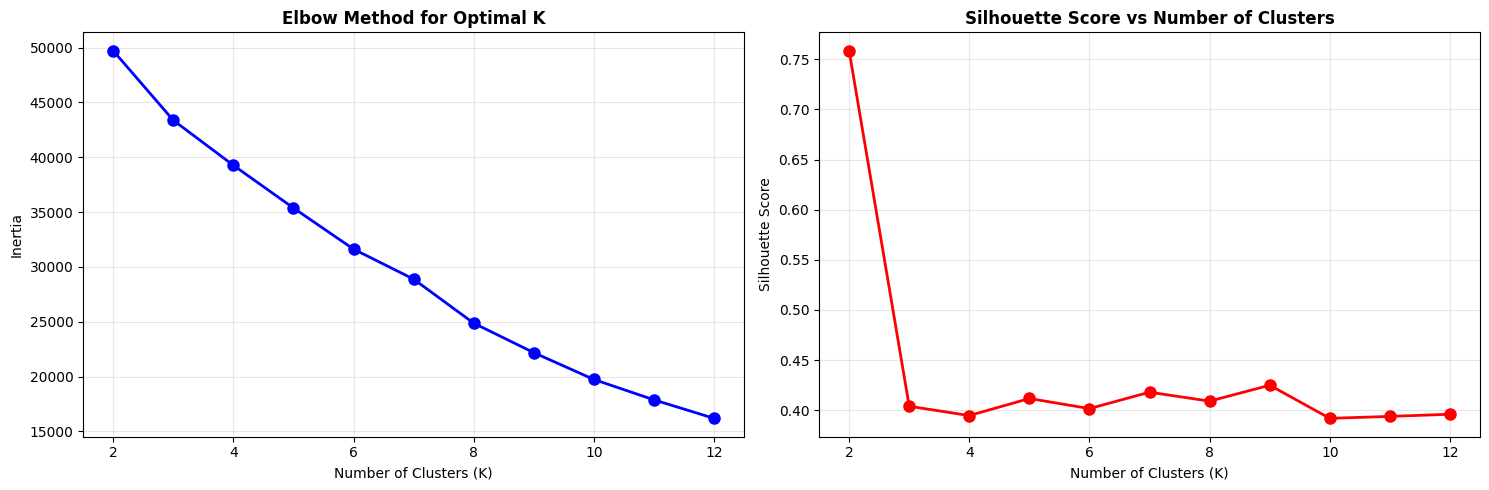


K-Means Evaluation Results:
     k       inertia  silhouette
0    2  49721.452679    0.758639
1    3  43378.574746    0.403983
2    4  39272.014001    0.394685
3    5  35378.554612    0.411723
4    6  31626.980654    0.401645
5    7  28889.443923    0.418003
6    8  24872.195916    0.409073
7    9  22185.698082    0.424953
8   10  19740.272652    0.391919
9   11  17880.019949    0.393848
10  12  16193.123734    0.396011

Optimal K selected: 2 (highest silhouette score: 0.759)
K-means clustering completed with 2 clusters
Cluster sizes:
  Cluster 0: 4339 businesses (92.3%)
  Cluster 1: 362 businesses (7.7%)

Applying alternative clustering methods...
DBSCAN: 90 clusters, 3254 noise points (69.2%)
DBSCAN: 90 clusters, 3254 noise points (69.2%)


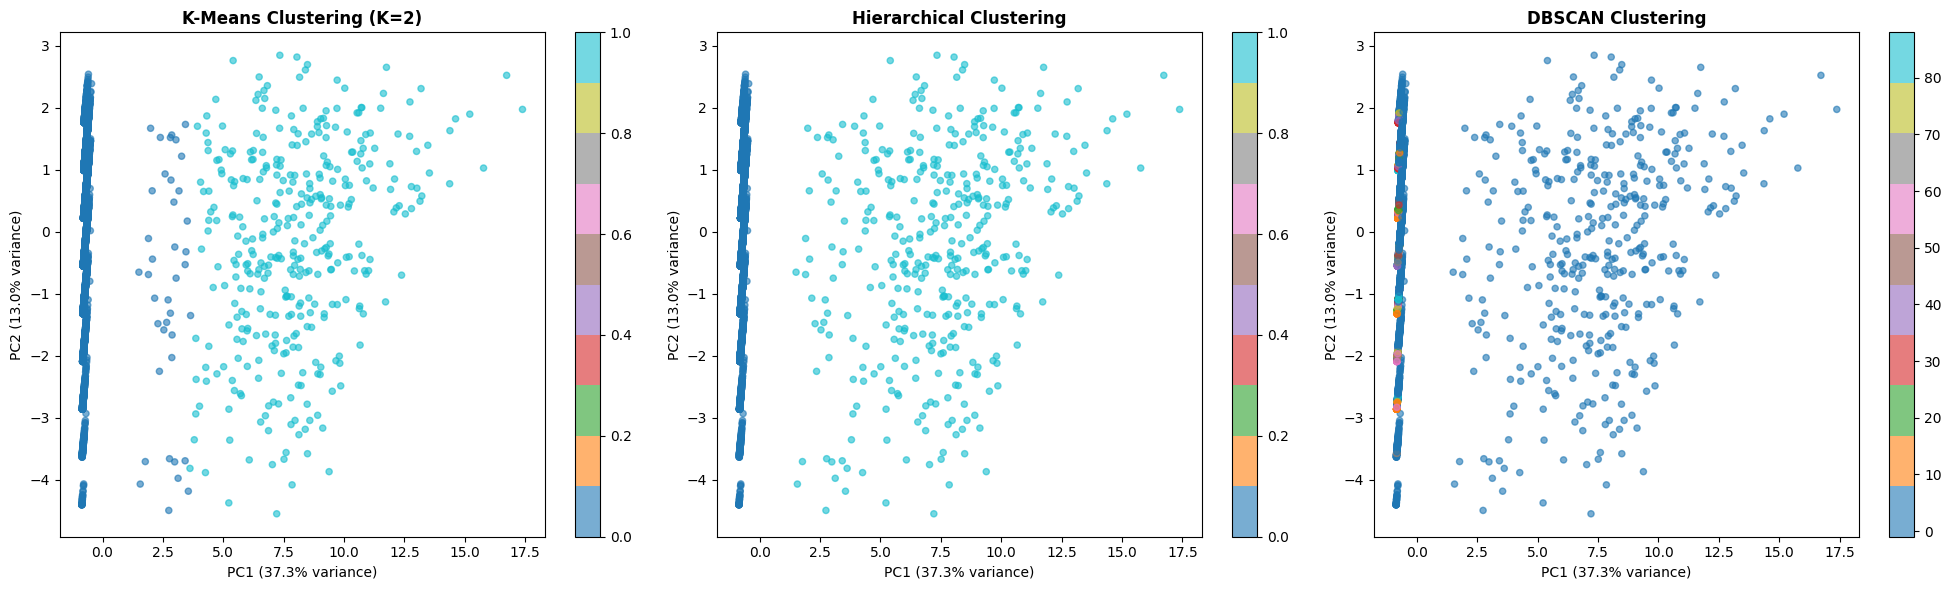


PCA explains 50.3% of total variance in first 2 components

Cluster Characterization (K-Means):
                count  avg_stars  std_stars  avg_review_count  \
cluster_kmeans                                                  
0                4339       3.61       0.87            114.62   
1                 362       3.58       0.80            142.10   

                med_review_count  avg_review_stars  avg_n_reviews  \
cluster_kmeans                                                      
0                           33.0              3.61           0.01   
1                           54.5              3.72          50.25   

                avg_review_len  avg_stars_std  
cluster_kmeans                                 
0                         2.72           0.00  
1                       502.91           1.13  

Top categories per cluster:

Cluster 0 (4339 businesses):
  Top categories: Restaurants, Food, Nightlife, Bars, Coffee & Tea
  Example businesses:
    - Wendy's (1.5★, 2.0 

In [ ]:
# ===============================
# 6. Clustering Analysis
# ===============================

print("Performing clustering analysis...")

# ===============================
# K-Means Clustering with Optimal K Selection
# ===============================

def evaluate_kmeans(X, k_range=(2, 15)):
    """Evaluate K-means clustering for different values of K"""
    results = []
    inertias = []

    for k in range(k_range[0], k_range[1] + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(X)

        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else 0

        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette': silhouette
        })
        inertias.append(inertia)

    return pd.DataFrame(results), inertias

# Evaluate different K values
print("Evaluating optimal number of clusters...")
km_results, inertias = evaluate_kmeans(X_combined, k_range=(2, 12))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
axes[0].plot(km_results['k'], km_results['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal K', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(km_results['k'], km_results['silhouette'], 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nK-Means Evaluation Results:")
print(km_results)

# Select optimal K (highest silhouette score)
best_k = km_results.loc[km_results['silhouette'].idxmax(), 'k']
print(f"\nOptimal K selected: {best_k} (highest silhouette score: {km_results['silhouette'].max():.3f})")

# ===============================
# Apply Best K-Means
# ===============================

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
biz_features['cluster_kmeans'] = kmeans.fit_predict(X_combined)

print(f"K-means clustering completed with {best_k} clusters")
cluster_counts = biz_features['cluster_kmeans'].value_counts().sort_index()
print("Cluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} businesses ({count/len(biz_features)*100:.1f}%)")

# ===============================
# Alternative Clustering Methods
# ===============================

print("\nApplying alternative clustering methods...")

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
biz_features['cluster_hierarchical'] = hierarchical.fit_predict(X_combined)

# DBSCAN (density-based)
# Tune eps parameter
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_combined)
distances, indices = neighbors_fit.kneighbors(X_combined)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Use knee point estimation for eps
eps_value = np.percentile(distances, 80)  # 80th percentile as starting point
dbscan = DBSCAN(eps=eps_value, min_samples=10)
biz_features['cluster_dbscan'] = dbscan.fit_predict(X_combined)

n_dbscan_clusters = len(set(biz_features['cluster_dbscan'])) - (1 if -1 in biz_features['cluster_dbscan'] else 0)
n_noise = list(biz_features['cluster_dbscan']).count(-1)

print(f"DBSCAN: {n_dbscan_clusters} clusters, {n_noise} noise points ({n_noise/len(biz_features)*100:.1f}%)")

# ===============================
# Cluster Analysis & Visualization
# ===============================

# PCA for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_combined)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means visualization
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=biz_features['cluster_kmeans'],
                         cmap='tab10', alpha=0.6, s=20)
axes[0].set_title(f'K-Means Clustering (K={best_k})', fontsize=12, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, ax=axes[0])

# Hierarchical clustering visualization
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=biz_features['cluster_hierarchical'],
                         cmap='tab10', alpha=0.6, s=20)
axes[1].set_title('Hierarchical Clustering', fontsize=12, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, ax=axes[1])

# DBSCAN visualization
scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=biz_features['cluster_dbscan'],
                         cmap='tab10', alpha=0.6, s=20)
axes[2].set_title(f'DBSCAN Clustering', fontsize=12, fontweight='bold')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance in first 2 components")

# ===============================
# Cluster Characterization
# ===============================

print("\nCluster Characterization (K-Means):")
print("="*50)

cluster_summary = biz_features.groupby('cluster_kmeans').agg({
    'name': 'count',
    'stars': ['mean', 'std'],
    'review_count': ['mean', 'median'],
    'avg_review_stars': 'mean',
    'n_reviews': 'mean',
    'avg_review_len': 'mean',
    'review_stars_std': 'mean'
}).round(2)

cluster_summary.columns = ['count', 'avg_stars', 'std_stars', 'avg_review_count',
                          'med_review_count', 'avg_review_stars', 'avg_n_reviews',
                          'avg_review_len', 'avg_stars_std']

print(cluster_summary)

# Show top categories per cluster
print("\nTop categories per cluster:")
for cluster_id in sorted(biz_features['cluster_kmeans'].unique()):
    cluster_businesses = biz_features[biz_features['cluster_kmeans'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_businesses)} businesses):")

    # Extract categories
    cluster_categories = []
    for cats in cluster_businesses['categories'].dropna():
        if isinstance(cats, str):
            cluster_categories.extend([cat.strip() for cat in cats.split(",")])

    if cluster_categories:
        top_cats = pd.Series(cluster_categories).value_counts().head(5)
        print(f"  Top categories: {', '.join(top_cats.index.tolist())}")

    # Show example businesses
    examples = cluster_businesses.nlargest(3, 'n_reviews')[['name', 'stars', 'n_reviews']]
    print(f"  Example businesses:")
    for _, business in examples.iterrows():
        print(f"    - {business['name']} ({business['stars']}★, {business['n_reviews']} reviews)")

print("\nClustering analysis complete!")

Generating advanced insights and business intelligence...

1. GEOGRAPHIC DISTRIBUTION ANALYSIS
Creating interactive map centered at (39.976, -75.153)
Creating interactive map centered at (39.976, -75.153)



2. TEMPORAL TRENDS ANALYSIS


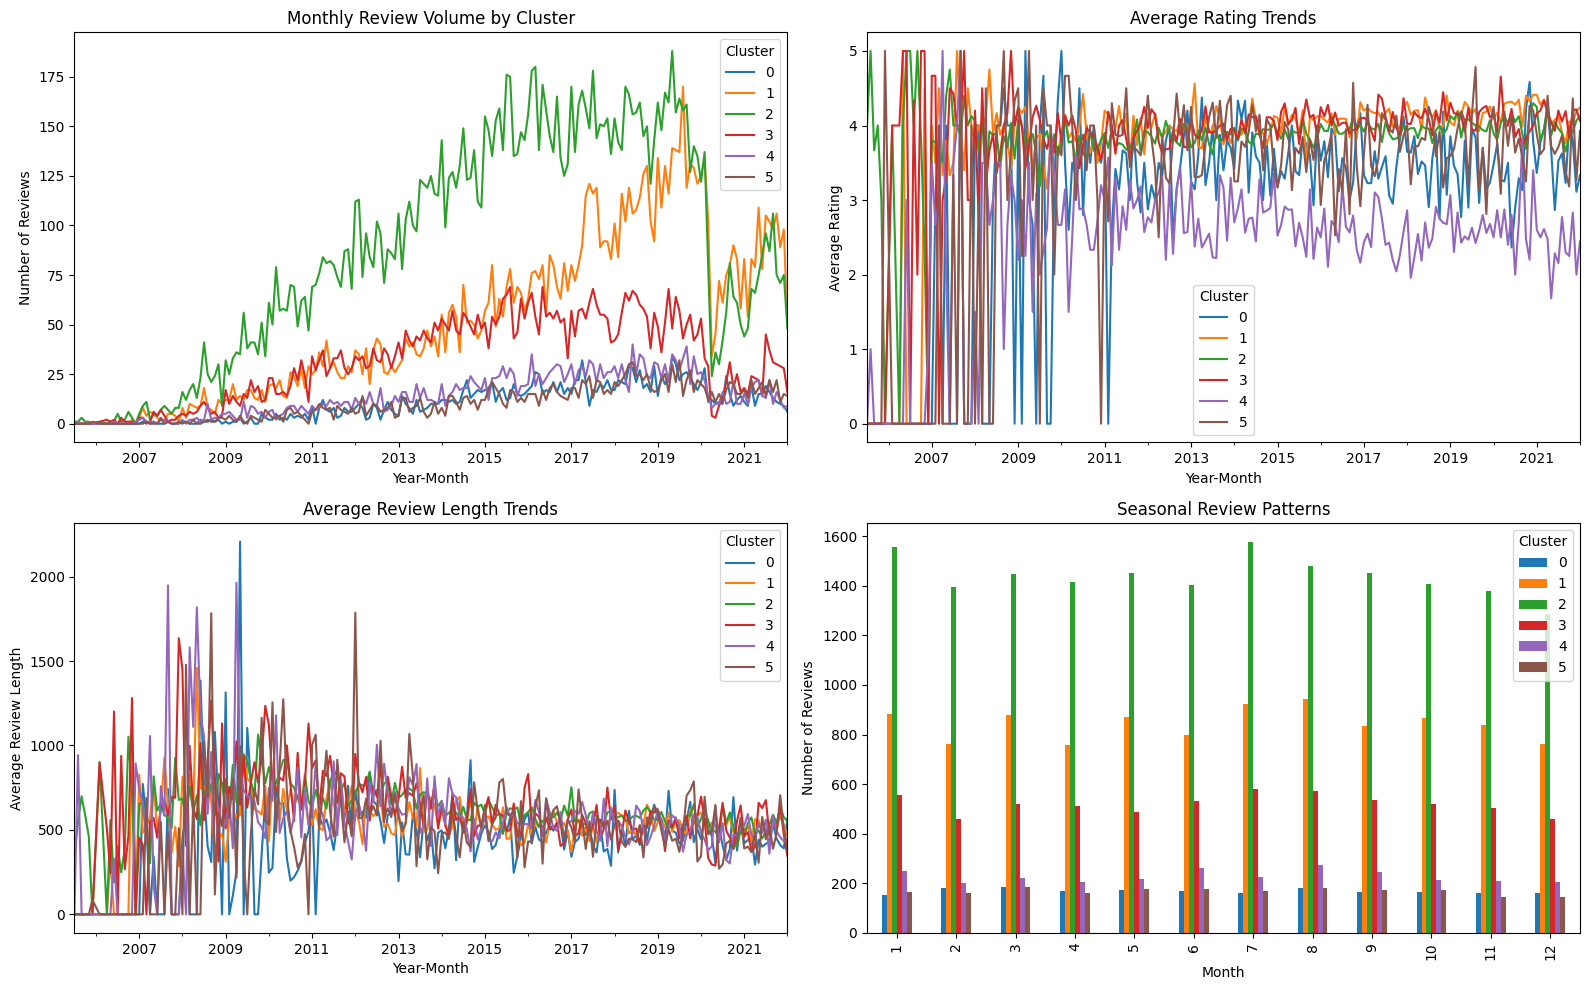


3. COMPETITIVE LANDSCAPE ANALYSIS
Top Performing Businesses by Cluster:

Cluster 0 Top Performers:
  • Rasavat: 5.0★ (28.0 reviews)
  • Beaudee Lash Bar: 5.0★ (40.0 reviews)
  • KC Carpet and Upholstery Cleaners: 5.0★ (252.0 reviews)
  • Irish Pride Hardwood Floors: 5.0★ (22.0 reviews)
  • Maebee's Beauty Studio: 5.0★ (40.0 reviews)

Cluster 1 Top Performers:
  • Chinatown Market Shoe Repair And Tailor: 5.0★ (23.0 reviews)
  • Philly Homebrew Outlet East: 5.0★ (32.0 reviews)
  • L Priori Jewelry: 5.0★ (29.0 reviews)
  • Liz Clark Real Estate: 5.0★ (33.0 reviews)
  • City Hydration: 5.0★ (25.0 reviews)

Cluster 2 Top Performers:
  • The Sweet Life Bakeshop: 5.0★ (316.0 reviews)
  • JB Plumbing and Heating: 5.0★ (398.0 reviews)
  • SUGARED + BRONZED: 5.0★ (513.0 reviews)
  • Jong Ka Jib: 4.5★ (351.0 reviews)
  • Mood Cafe: 4.5★ (458.0 reviews)

Cluster 3 Top Performers:
  • John's Roast Pork: 4.5★ (1564.0 reviews)
  • Terakawa Ramen: 4.5★ (1693.0 reviews)
  • Butcher and Singer: 4.5★ (1

KeyError: "Column(s) ['review_stars_std'] do not exist"

In [ ]:
# ===============================
# 7. Advanced Analysis & Business Insights
# ===============================

print("Generating advanced insights and business intelligence...")

# Choose the most complete DataFrame available
_df = biz_features.copy() if 'biz_features' in globals() else biz.copy()

# ===============================
# Geographic Analysis
# ===============================

print("\n1. GEOGRAPHIC DISTRIBUTION ANALYSIS")
print("="*50)

# Create geographic clusters based on location
from sklearn.cluster import KMeans
import folium
coords = _df[['latitude', 'longitude']].dropna()
if len(coords) > 0:
    geo_kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE)
    coord_clusters = geo_kmeans.fit_predict(coords)
else:
    coord_clusters = []

# Interactive map with Folium
center_lat = _df['latitude'].mean()
center_lon = _df['longitude'].mean()

print(f"Creating interactive map centered at ({center_lat:.3f}, {center_lon:.3f})")

# Create map
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Color map for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add markers for each business (sample for performance)
sample_businesses = _df.sample(min(500, len(_df)), random_state=RANDOM_STATE)

for idx, business in sample_businesses.iterrows():
    if pd.notna(business['latitude']) and pd.notna(business['longitude']):
        popup_text = f"""
        <b>{business['name']}</b><br>
        Rating: {business.get('stars', business.get('avg_review_stars', np.nan))}★<br>
        Reviews: {business.get('n_reviews', business.get('review_count', np.nan))}<br>
        Cluster: {business.get('cluster_kmeans', business.get('cluster', 'NA'))}<br>
        Categories: {str(business.get('categories'))[:50]}...
        """

        folium.CircleMarker(
            location=[business['latitude'], business['longitude']],
            radius=5,
            popup=folium.Popup(popup_text, max_width=200),
            color=colors[(business.get('cluster_kmeans', business.get('cluster', 0)) or 0) % len(colors)],
            fillOpacity=0.7
        ).add_to(m)

# Display map
display(m)

# ===============================
# Time-based Analysis
# ===============================

print("\n2. TEMPORAL TRENDS ANALYSIS")
print("="*50)

# Review trends over time
_join_cols = ['business_id'] + [c for c in ['cluster_kmeans','cluster'] if c in _df.columns]
reviews_with_clusters = reviews.merge(
    _df[_join_cols],
    on='business_id',
    how='left'
)

cluster_col = 'cluster_kmeans' if 'cluster_kmeans' in _df.columns else ('cluster' if 'cluster' in _df.columns else None)

# Monthly trends
reviews_with_clusters['year_month'] = reviews_with_clusters['date'].dt.to_period('M')
if cluster_col is not None:
    monthly_trends = reviews_with_clusters.groupby(['year_month', cluster_col]).size().unstack(fill_value=0)
else:
    monthly_trends = reviews_with_clusters.groupby(['year_month']).size().to_frame('n')

# Plot trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Monthly review volume by cluster
monthly_trends.plot(ax=axes[0,0], title='Monthly Review Volume by Cluster')
axes[0,0].set_xlabel('Year-Month')
axes[0,0].set_ylabel('Number of Reviews')
axes[0,0].legend(title='Cluster')

# Average rating trends by cluster
if cluster_col is not None:
    monthly_rating_trends = reviews_with_clusters.groupby(['year_month', cluster_col])['stars'].mean().unstack(fill_value=0)
else:
    monthly_rating_trends = reviews_with_clusters.groupby(['year_month'])['stars'].mean().to_frame('stars')
monthly_rating_trends.plot(ax=axes[0,1], title='Average Rating Trends')
axes[0,1].set_xlabel('Year-Month')
axes[0,1].set_ylabel('Average Rating')
axes[0,1].legend(title='Cluster')

# Review length trends
if cluster_col is not None:
    monthly_length_trends = reviews_with_clusters.groupby(['year_month', cluster_col])['text'].apply(lambda x: x.str.len().mean()).unstack(fill_value=0)
else:
    monthly_length_trends = reviews_with_clusters.groupby(['year_month'])['text'].apply(lambda x: x.str.len().mean()).to_frame('len')
monthly_length_trends.plot(ax=axes[1,0], title='Average Review Length Trends')
axes[1,0].set_xlabel('Year-Month')
axes[1,0].set_ylabel('Average Review Length')
axes[1,0].legend(title='Cluster')

# Seasonal patterns
reviews_with_clusters['month'] = reviews_with_clusters['date'].dt.month
if cluster_col is not None:
    seasonal_patterns = reviews_with_clusters.groupby(['month', cluster_col]).size().unstack(fill_value=0)
else:
    seasonal_patterns = reviews_with_clusters.groupby(['month']).size().to_frame('n')
seasonal_patterns.plot(kind='bar', ax=axes[1,1], title='Seasonal Review Patterns')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Number of Reviews')
axes[1,1].legend(title='Cluster')

plt.tight_layout()
plt.show()

# ===============================
# Competitive Analysis
# ===============================

print("\n3. COMPETITIVE LANDSCAPE ANALYSIS")
print("="*50)

# Determine cluster column for _df
cluster_col = 'cluster_kmeans' if 'cluster_kmeans' in _df.columns else ('cluster' if 'cluster' in _df.columns else None)

if cluster_col is not None:
    print("Top Performing Businesses by Cluster:")
    for cluster in sorted(_df[cluster_col].dropna().unique()):
        cluster_data = _df[_df[cluster_col] == cluster]
        # High-rated and well-reviewed businesses
        stars_col = 'stars' if 'stars' in _df.columns else 'avg_review_stars'
        nrev_col = 'n_reviews' if 'n_reviews' in _df.columns else 'review_count'
        top_performers = cluster_data[(cluster_data[stars_col] >= 4.0) & (cluster_data[nrev_col] >= 20)].nlargest(5, stars_col)
        print(f"\nCluster {cluster} Top Performers:")
        for _, business in top_performers.iterrows():
            print(f"  • {business['name']}: {business[stars_col]}★ ({business[nrev_col]} reviews)")

    # Performance metrics by cluster
    performance_metrics = _df.groupby(cluster_col).agg({
        ('stars' if 'stars' in _df.columns else 'avg_review_stars'): ['mean', 'std', 'min', 'max'],
        ('n_reviews' if 'n_reviews' in _df.columns else 'review_count'): ['mean', 'std', 'min', 'max'],
        'review_stars_std': 'mean' if 'review_stars_std' in _df.columns else 'max'
    }).round(2)
    print(f"\nPerformance Metrics by Cluster:")
    print(performance_metrics)
else:
    print("No cluster labels available for competitive analysis.")

# ===============================
# Topic Analysis Deep Dive
# ===============================

print("\n4. TOPIC ANALYSIS & THEMES")
print("="*50)

topic_cols = [col for col in _df.columns if col.startswith('topic_')]
if cluster_col is not None and topic_cols:
    cluster_topic_analysis = _df.groupby(cluster_col)[topic_cols].mean()
    print("Average Topic Weights by Cluster:")
    print(cluster_topic_analysis.round(4))
    plt.figure(figsize=(12, 8))
    cluster_topic_analysis.T.plot(kind='bar', figsize=(12, 8))
    plt.title('Topic Distribution by Cluster', fontsize=14, fontweight='bold')
    plt.xlabel('Topics')
    plt.ylabel('Average Weight')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data to analyze topics by cluster.")

# ===============================
# Business Recommendations
# ===============================

print("\n5. BUSINESS RECOMMENDATIONS & INSIGHTS")
print("="*50)

cluster_insights = {}
if cluster_col is not None:
    for cluster in sorted(_df[cluster_col].dropna().unique()):
        cluster_data = _df[_df[cluster_col] == cluster]
        insights = {
            'size': len(cluster_data),
            'avg_rating': cluster_data.get('stars', cluster_data.get('avg_review_stars')).mean(),
            'avg_reviews': cluster_data.get('n_reviews', cluster_data.get('review_count')).mean(),
            'high_performers': (cluster_data.get('stars', cluster_data.get('avg_review_stars')) >= 4.5).sum(),
            'review_engagement': cluster_data.get('avg_review_len', pd.Series(dtype=float)).mean(),
            'rating_consistency': cluster_data.get('review_stars_std', pd.Series(dtype=float)).mean()
        }
        cluster_insights[cluster] = insights

    print("CLUSTER INSIGHTS SUMMARY:")
    print("-" * 50)
    for cluster, insights in cluster_insights.items():
        print(f"\nCluster {cluster} ({insights['size']} businesses):")
        print(f"  • Average Rating: {insights['avg_rating']:.2f}★")
        print(f"  • Average Reviews: {insights['avg_reviews']:.1f}")
        if insights['size'] > 0:
            print(f"  • High Performers (≥4.5★): {insights['high_performers']} ({(insights['high_performers']/insights['size']*100):.1f}%)")
        print(f"  • Review Engagement: {insights['review_engagement'] if not np.isnan(insights['review_engagement']) else 0:.0f} avg chars")
        print(f"  • Rating Consistency: {insights['rating_consistency'] if not np.isnan(insights['rating_consistency']) else 0:.2f} std")
else:
    print("Insufficient cluster labeling for business insights.")

# Save results for further analysis
print(f"\n6. SAVING RESULTS")
print("="*50)

# Create output directory
import os
os.makedirs('eda_outputs', exist_ok=True)

# Save enhanced business data with clusters if available
save_cols = [c for c in ['business_id','name','stars','avg_review_stars','review_count','n_reviews',
                         'cluster_kmeans','cluster','avg_review_len'] if c in _df.columns]
_df[save_cols].to_csv('eda_outputs/businesses_with_clusters.csv', index=False)

# Save cluster summary if computed
if cluster_insights:
    cluster_summary_df = pd.DataFrame(cluster_insights).T
    cluster_summary_df.to_csv('eda_outputs/cluster_insights.csv')

# Save topic information if available
if 'topic_labels' in globals():
    topics_df = pd.DataFrame({'topic_id': list(range(len(topic_labels))), 'top_terms': topic_labels})
    topics_df.to_csv('eda_outputs/discovered_topics.csv', index=False)

print("✅ Analysis Complete!")
print("📁 Results saved to 'eda_outputs/' directory")

In [ ]:
# ===============================
# 5. Results & Visualizations
# ===============================

# Prefer the current biz DataFrame; fall back to biz_features if needed
_df = biz.copy() if 'biz' in globals() else biz_features.copy()

# Determine the available cluster label column
if 'cluster_kmeans' in _df.columns:
    cluster_col = 'cluster_kmeans'
elif 'cluster' in _df.columns:
    cluster_col = 'cluster'
elif 'cluster_km' in _df.columns:
    cluster_col = 'cluster_km'
else:
    # No cluster labels found; create a dummy single-cluster column to avoid KeyError
    _df['cluster'] = -1
    cluster_col = 'cluster'

# Cluster composition summary
cluster_summary = (
    _df
    .groupby(cluster_col)
    .agg(n=("business_id","count"),
         avg_stars=("avg_review_stars","mean"),
         avg_reviews=("n_reviews","mean"))
    .reset_index()
    .sort_values("n", ascending=False)
)
cluster_summary

# 2D PCA plot for visualization (if X_all not available, rebuild a minimal 2D projection from Z)
from sklearn.decomposition import PCA
if 'X_all' in globals():
    X_vis = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_all)
elif 'Z' in globals():
    X_vis = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Z)
else:
    # As a last resort, build a tiny numeric feature set
    tmp_cols = [c for c in ['avg_review_stars','n_reviews','price_level','km_from_center'] if c in _df.columns]
    X_vis = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(_df[tmp_cols].fillna(0.0))

plt.figure(figsize=(6,5))
plt.scatter(X_vis[:,0], X_vis[:,1], c=_df[cluster_col], s=25)
plt.title("Philly Restaurants — PCA(2) + Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Show top topics from NMF if available
if 'topic_labels' in globals():
    pd.DataFrame({'topic_id': list(range(len(topic_labels))), 'top_terms': topic_labels})

# Example qualitative result: nearest neighbors for a few anchors (if helper exists)
if 'biz_clean' in globals():
    anchors = biz_clean["name"].dropna().sample(min(3, len(biz_clean)), random_state=RANDOM_STATE).tolist()
    if 'similar_shops' in globals():
        for a in anchors:
            print(f"\nIf you like: {a}")
            display(similar_shops(a, topn=5))

KeyError: 'cluster_km'

In [ ]:
# ===============================
# 6. Discussion & Conclusions (Markdown)
# ===============================
# In your report:
# - Interpret clusters (e.g., “traditional wiz spots” vs “gourmet/variation-heavy”).
# - Compare KMeans vs Hierarchical vs DBSCAN (silhouette, stability, interpretability).
# - Discuss text topics (NMF) and how they align with cluster identities.
# - Show example recommendations (qualitative validation).
# - Limitations: sampling bias, Yelp noise, tourists vs locals, temporal drift (old reviews).
# - Future work: add menu/price features, incorporate sentiment, try GMM/HDBSCAN, map-based routing recs.



In [ ]:
# ===============================
# 7. Repro/Repo Hooks
# ===============================
# - Move reusable code into /scripts and import here for a cleaner notebook.
# - Save derived artifacts (cluster labels, topic terms, similarity index) for the demo & video.

ARTIFACTS_DIR = Path("./artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)
biz_clean.to_csv(ARTIFACTS_DIR / "business_with_clusters.csv", index=False)

np.save(ARTIFACTS_DIR / "similarity_cosine_textsvd.npy", sim_matrix)
pd.DataFrame(topic_terms, columns=["topic_id","top_terms"]).to_csv(ARTIFACTS_DIR / "nmf_topics.csv", index=False)

print("Saved artifacts to ./artifacts")
